In [1]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats
from scipy.stats import linregress

import cftime


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [6]:
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
#    cube = extract_month(cube,12) # get DEC
    return cube


In [7]:
model_datasets_prep = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


In [8]:
model_n34 = model_datasets_prep["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep["ACCESS-ESM1-5"],12)


In [9]:
# Create a CubeList with both cubes
combined_cubes = iris.cube.CubeList([model_n34, model_n34_dec])

# Save the CubeList to a single NetCDF file
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lifecycle_combined.nc'
iris.save(combined_cubes, output_filepath, netcdf_format="NETCDF4")

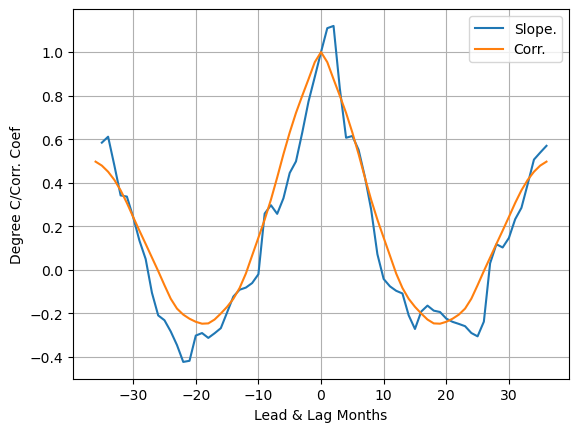

In [16]:
import xarray as xr
ds = xr.open_dataset(output_filepath)

leadlagyr = 2
n34 = ds['tos'].squeeze()
n34_dec = n34[11::12]
n34_dec_ct = n34_dec[leadlagyr:-leadlagyr-1]

event_years = n34_dec_ct.time.dt.year

# Create an empty array to store the years of interest
years_of_interest_array = np.empty((len(event_years), leadlagyr*3), dtype=int)

# Fill the array with the years of interest for each event year
for i, year in enumerate(event_years):
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array[i] = [year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3]


n34_selected = []

for i in range(len(years_of_interest_array)):
    # Select the data for the current year and append it to n34_selected
    n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))



import sacpy as scp

def autoCorrelation(x, lags):
    N = len(x)
    auto_corr = np.correlate(x, x, mode='full')
    assert N >= lags - 1
    auto_corr = auto_corr[N - lags - 1: N + lags]
    auto_corr = auto_corr / np.max(auto_corr)
    return auto_corr

n34_selected_array = np.array(n34_selected)  # Convert the list to a NumPy array
slope = scp.LinReg( n34_dec_ct.values, n34_selected_array).slope

acf1 = autoCorrelation(n34, 36)

plt.plot(np.arange(1, 73) - 36, slope, label='Slope.')
plt.plot(np.arange(1, 74) - 37, acf1, label='Corr.')

plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C/Corr. Coef')
#plt.title('Plot Title')
plt.legend(); plt.grid()
#plt.savefig('enso_n34_reg_ssta.png', bbox_inches='tight')
plt.show()

# note for Felicity
* so far I have to save to netcdf and read in as xarray so that I can do the plot as shown above
* if possible I hope you can help me so that I don't need to do that and can plot directly

In [ ]:
# here I was using xarray
ds = readnc('n34_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_195001-201412.nc')

# how can I convert to use CUBE to make this code working?

leadlagyr = 2
n34 = ds['n34'].squeeze()
n34_dec = n34[11::12]
n34_dec_ct = n34_dec[leadlagyr:-leadlagyr-1]

event_years = n34_dec_ct.time.dt.year

# Select the data for the years of interest from n34
n34_cases = n34.sel(time=n34.time.dt.year.isin(event_years))

# Create an empty array to store the years of interest
years_of_interest_array = np.empty((len(event_years), leadlagyr*3), dtype=int)

# Fill the array with the years of interest for each event year
for i, year in enumerate(event_years):
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array[i] = [year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3]


n34_selected = []

for i in range(len(years_of_interest_array)):
    # Select the data for the current year and append it to n34_selected
    n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))

import sacpy as scp
n34_selected_array = np.array(n34_selected)  # Convert the list to a NumPy array
slope = scp.LinReg( n34_dec_ct.values, n34_selected_array).slope

acf1 = autoCorrelation(n34, 36)



In [ ]:
plt.plot(np.arange(1, 73) - 36, slope, label='Slope.')
plt.plot(np.arange(1, 74) - 37, acf1, label='Corr.')

plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C/Corr. Coef')
#plt.title('Plot Title')
plt.legend(); plt.grid()
plt.savefig('enso_n34_reg_ssta.png', bbox_inches='tight')
plt.show()
